# 1. Introduction

# 2. Wrangling

To prepare the data for analysis, we first loaded the `players.csv` and `sessions.csv` files and inspected their structure with `glimpse()`. The players dataset contains demographics, subscription status, and total played hours for each user. Following our project plan, we removed players with `played_hours == 0`, since these users do not provide any behavioural information relevant to predicting subscription. We also excluded rows with missing values in `subscribe` or `played_hours`, and converted the categorical variables (`experience`, `gender`, `subscribe`) into factors. 

The sessions dataset required additional wrangling because its timestamps were stored as character strings. Using `separate()`, we extracted date, hour, and minute components from each start and end time, and computed a new variable `duration_min` to represent each session length. We removed sessions with zero or negative duration, then summarized each user's gameplay by calculating their number of sessions (`n_sessions`) and average session length (`mean_session_min`). These summaries were merged back into the cleaned players dataset using `left_join()`, producing the final dataset.

We then generated summary statistics and exploratory plots to understand gameplay behaviour. The distribution of played hours is highly right-skewed, with most players having less than one hour of playtime and a few players recording extremely high totals. Box-plots comparing played hours by subscription status show that subscribed players tend to have slighly higher engagement on average.

In [1]:
library(tidyverse)
library(tidymodels)
library(themis)

players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")
glimpse(players)
glimpse(sessions)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…
Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+

In [2]:
# Wrangling - Clean players dataset
players_clean <- players |>
    filter(!is.na(subscribe), !is.na(played_hours), played_hours > -1) |>
    mutate(subscribe = factor(subscribe), gender = factor(gender), experience = factor(experience))
glimpse(players_clean)

Rows: 196
Columns: 7
$ experience   <fct> Pro, Veteran, Veteran, Amateur, Regular, Amateur, Regular…
$ subscribe    <fct> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <fct> Male, Male, Male, Female, Male, Female, Female, Male, Mal…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…


In [3]:
# Wrangling - Clean sessions dataset
sessions_clean <- sessions |>
    separate(start_time, into = c("start_date", "start_clock"), sep = " ") |>
    separate(end_time, into = c("end_date", "end_clock"), sep = " ") |>
    separate(start_clock, into = c("start_hour", "start_minute"), sep = ":", convert = TRUE) |>
    separate(end_clock, into = c("end_hour", "end_minute"), sep = ":", convert = TRUE) |>
    mutate(duration_min = (end_hour - start_hour) * 60 + (end_minute - start_minute)) |>
    filter(duration_min > 0)
glimpse(sessions_clean)


Rows: 1,441
Columns: 10
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_date          <chr> "30/06/2024", "17/06/2024", "25/07/2024", "25/07/2…
$ start_hour          <int> 18, 23, 17, 3, 16, 15, 7, 2, 2, 5, 1, 15, 2, 0, 18…
$ start_minute        <int> 12, 33, 34, 22, 1, 8, 12, 13, 31, 13, 31, 15, 32, …
$ end_date            <chr> "30/06/2024", "17/06/2024", "25/07/2024", "25/07/2…
$ end_hour            <int> 18, 23, 17, 3, 16, 17, 7, 2, 2, 5, 1, 15, 3, 3, 18…
$ end_minute          <int> 24, 46, 57, 58, 12, 10, 21, 30, 49, 52, 35, 43, 12…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ duration_min        <dbl> 12, 13, 23, 36, 11, 122, 9, 17, 18, 39, 4, 28, 40,…


In [4]:
# Summarize sessions per player
sessions_summary <- sessions_clean |>
    group_by(hashedEmail) |>
    summarize(n_sessions = n(), mean_session_min = mean(duration_min))
glimpse(sessions_summary)

Rows: 124
Columns: 3
$ hashedEmail      <chr> "0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95…
$ n_sessions       <int> 1, 1, 1, 13, 2, 1, 1, 40, 1, 1, 1, 2, 1, 1, 75, 1, 1,…
$ mean_session_min <dbl> 45.000000, 30.000000, 11.000000, 32.153846, 35.000000…


In [5]:
# Join players + session summaries
players_final <- players_clean |>
    left_join(sessions_summary, by = "hashedEmail")
glimpse(players_final)

Rows: 196
Columns: 9
$ experience       <fct> Pro, Veteran, Veteran, Amateur, Regular, Amateur, Reg…
$ subscribe        <fct> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRU…
$ hashedEmail      <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee97…
$ played_hours     <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.…
$ name             <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Ad…
$ gender           <fct> Male, Male, Male, Female, Male, Female, Female, Male,…
$ Age              <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22…
$ n_sessions       <int> 22, 3, 1, 1, 1, NA, NA, 1, 1, NA, 3, NA, 1, 1, NA, NA…
$ mean_session_min <dbl> 58.63636, 85.00000, 5.00000, 50.00000, 9.00000, NA, N…


In [6]:
# Summary stats

# Overall
players_final |>
    summarize(
        mean_hours = mean(played_hours),
        median_hours = median(played_hours),
        sd_hours = sd(played_hours),
        subscription_rate = mean(subscribe == "TRUE"))

# Subscription rate by experience
players_final |>
    group_by(experience) |>
    summarize(subscription_rate = mean(subscribe == "TRUE"))

# Subscription rate by gender
players_final |>
    group_by(gender) |>
    summarize(subscription_rate = mean(subscribe == "TRUE"))

mean_hours,median_hours,sd_hours,subscription_rate
<dbl>,<dbl>,<dbl>,<dbl>
5.845918,0.1,28.35734,0.7346939


experience,subscription_rate
<fct>,<dbl>
Amateur,0.7142857
Beginner,0.7714286
Pro,0.7142857
Regular,0.8055556
Veteran,0.6875000


gender,subscription_rate
<fct>,<dbl>
Agender,1.0000000
Female,0.7837838
Male,0.7500000
Non-binary,0.7333333
Other,1.0000000
Prefer not to say,0.3636364
Two-Spirited,0.6666667


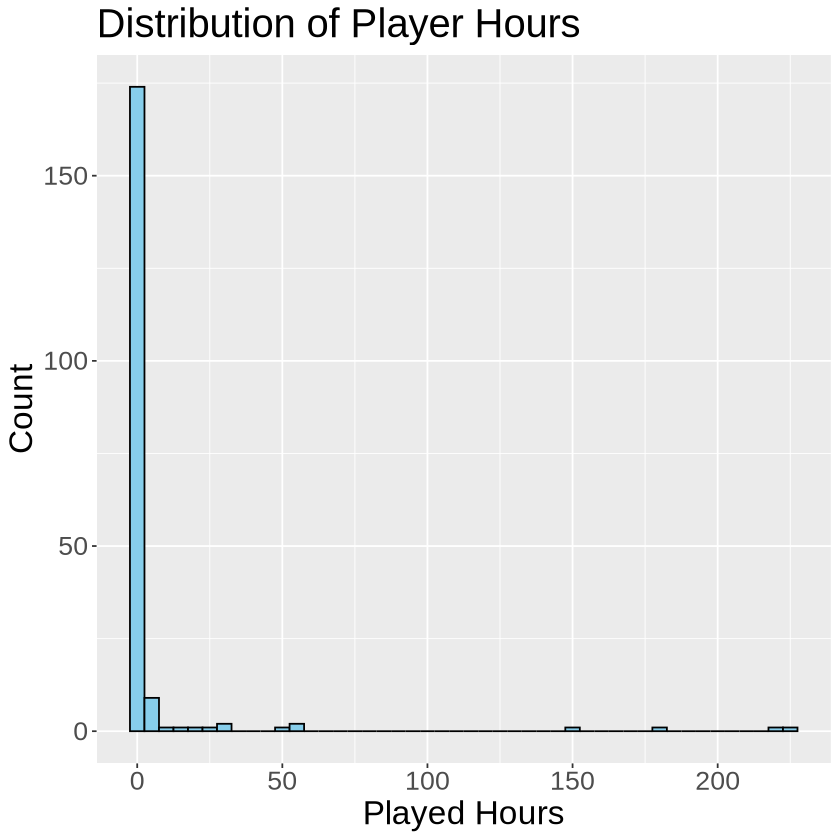

In [7]:
options(repr.plot_height = 20, repr.plot_width = 20)
ggplot(players_final, aes(x = played_hours)) +
    geom_histogram(binwidth = 5, fill = "skyblue", color = "black") +
    labs(x = "Played Hours", y = "Count", title = "Distribution of Player Hours") +
    theme(text = element_text(size = 20))

**Figure 1.** Distribution of played hours (full scale). This histogram shows that the distribution is extremely right-skewed, which a few players recording very high totals. 

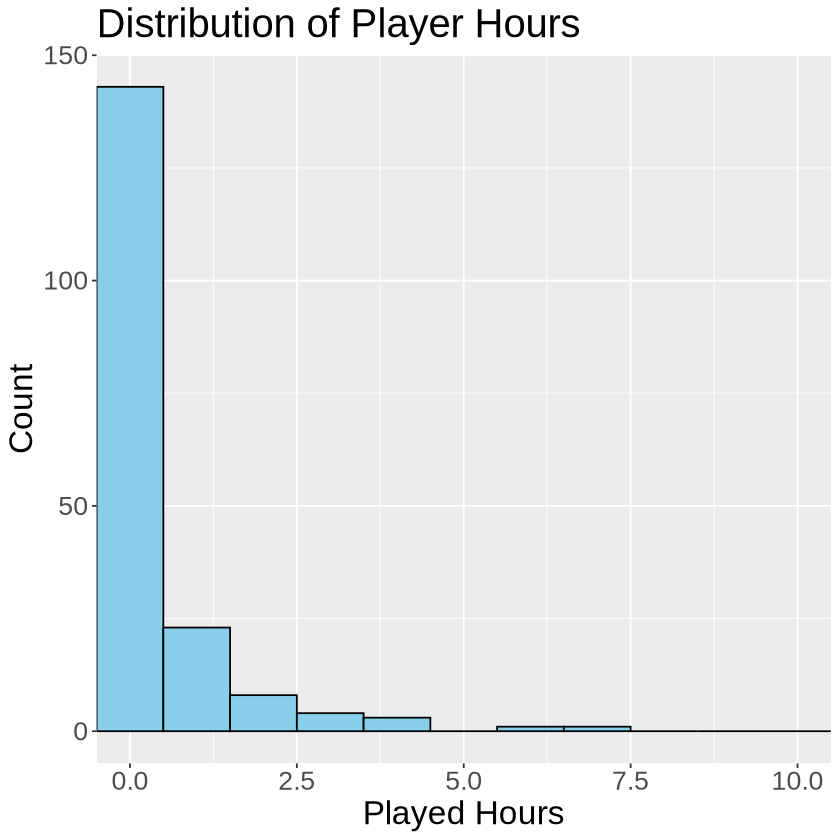

In [8]:
options(repr.plot_height = 20, repr.plot_width = 20)
ggplot(players_final, aes(x = played_hours)) +
    geom_histogram(binwidth = 1, fill = "skyblue", color = "black") +
    coord_cartesian(xlim = c(0, 10)) +
    labs(x = "Played Hours", y = "Count", title = "Distribution of Player Hours") +
    theme(text = element_text(size = 20))

**Figure 2.** Distribution of played hours (0-10 hours). Zooming in on the lower range shows that most players have played under two hours. 

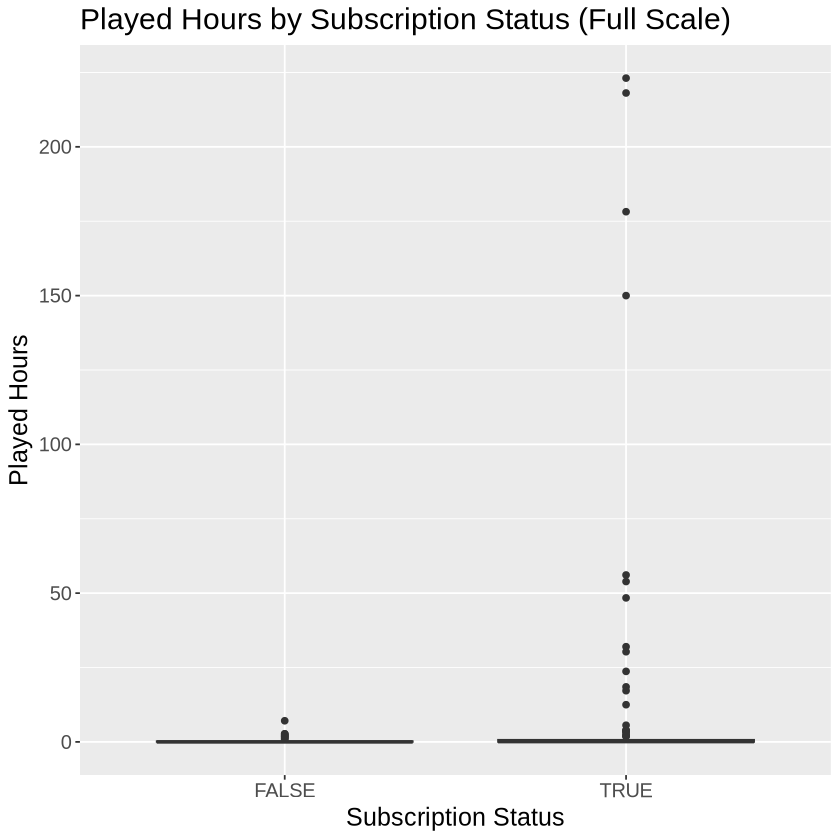

In [9]:
ggplot(players_final, aes(x = subscribe, y = played_hours)) +
    geom_boxplot(fill = "skyblue") +
    labs(x = "Subscription Status", y = "Played Hours", title = "Played Hours by Subscription Status (Full Scale)") +
    theme(text = element_text(size = 15))

**Figure 3.** Boxplot of played hours by subscription status (full scale). Subscribed players tend to show slightly higher engagement.

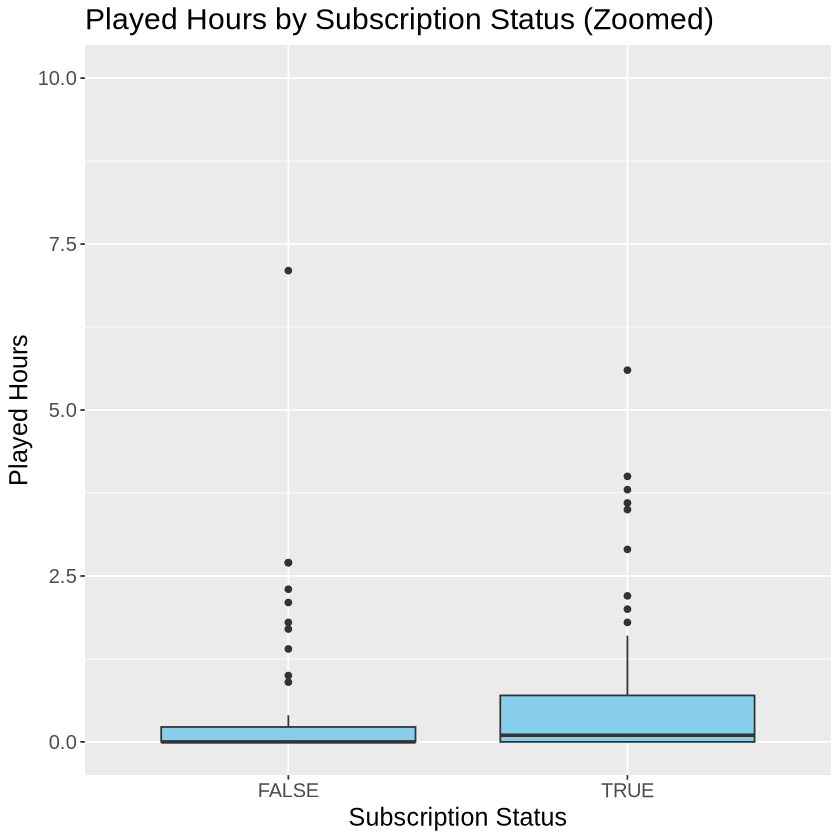

In [10]:
ggplot(players_final, aes(x = subscribe, y = played_hours)) +
    geom_boxplot(fill = "skyblue") +
    coord_cartesian(ylim = c(0, 10)) +
    labs(x = "Subscription Status", y = "Played Hours", title = "Played Hours by Subscription Status (Zoomed)") +
    theme(text = element_text(size = 15))

**Figure 4.** Boxplot of played hours by subscription status, zoomed to 0-10 hours for clarity. This highlights that most players play very little. 

These cleaned and summarized data will be used by the modeling section to fit logistic regression models predicting subscription from gameplay behaviour and demographic variables. 

# 3. Dealing With Visualizations

# 4.1 Data Analysis - Part 1: Classification Model
Many different approaches to a classification model for newspaper subscriptions are possible. Therefore, there are specific parameters that have been set:
* 70/30 training/testing split
* 5-fold cross-validation
* target: subscribe
* predictors: experience, age, played_hours

In [11]:
#Make the experience numerical
players_for_model <- players_final |>
    mutate(experience = as.numeric(factor(experience, levels = c("Amateur", "Beginner", "Regular", "Pro", "Veteran")))) |>
    na.omit()
head(players_for_model)

experience,subscribe,hashedEmail,played_hours,name,gender,Age,n_sessions,mean_session_min
<dbl>,<fct>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<int>,<dbl>
4,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,22,58.63636
5,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,3,85.00000
5,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,1,5.00000
1,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,1,50.00000
3,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,1,9.00000
1,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21,1,5.00000


In [12]:
set.seed(1234)

#Splitting into training and testing
player_split <- initial_split(players_for_model, prop = .7, strata = subscribe)
player_training <- training(player_split)
player_testing <- testing(player_split)

In [13]:
#All the recipes:
#played_hours = H, Age = A, experience = E

newspaper_AE_recipe <- recipe(subscribe ~ experience + Age, data = player_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors()) 
                        

newspaper_AH_recipe <- recipe(subscribe ~ played_hours + Age, data = player_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

newspaper_HE_recipe <- recipe(subscribe ~ experience + played_hours, data = player_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

newspaper_A_recipe <- recipe(subscribe ~ Age, data = player_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors()) 

newspaper_H_recipe <- recipe(subscribe ~ played_hours, data = player_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

newspaper_E_recipe <- recipe(subscribe ~ experience, data = player_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors()) 

#Recipe for all 3 parameters
newspaper_3C3_recipe <- recipe(subscribe ~ experience + played_hours + Age, data = player_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

In [14]:
set.seed(1234)

#TUNING K
train_fold <- vfold_cv(player_training, v=5, strata = subscribe)
k_vals <- tibble(neighbors = seq(from = 2, to = 10, by = 1))

#Make model for k tuning
knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('classification')

#initialize tibble
highest_acc_per_recipe = tibble(recipe_name = character(), accuracy = numeric())

tune_k <- function(recipe, recipe_name) {
    #Workflow to get metrics for k tuning
    newspaper_workflow <- workflow() |>
        add_recipe(recipe) |>
        add_model(knn_tune) |>
        tune_grid(resamples = train_fold, grid = k_vals) |>
        collect_metrics()

    #Find the highest accuracy per recipe
    highest_accuracy <- newspaper_workflow |>
        filter(.metric == 'accuracy') |>
        arrange(desc(mean)) |>
        slice(1) |>
        pull(mean)

    #Add to tibble
    highest_acc_per_recipe <<- highest_acc_per_recipe |>
        add_row(recipe_name = recipe_name, accuracy = highest_accuracy)
    
    }

tune_k(newspaper_3C3_recipe, '3C3 Recipe')
tune_k(newspaper_AE_recipe, 'AE Recipe')
tune_k(newspaper_AH_recipe, 'AH Recipe')
tune_k(newspaper_HE_recipe, 'HE Recipe')
tune_k(newspaper_A_recipe, 'A Recipe')
tune_k(newspaper_H_recipe, 'H Recipe')
tune_k(newspaper_E_recipe, 'E Recipe')

ordered_highest_acc_per_recipe <- highest_acc_per_recipe |>
    arrange(desc(accuracy))

ordered_highest_acc_per_recipe

# The highest accuracy is found with Age and Mean Played Hours as predictors

recipe_name,accuracy
<chr>,<dbl>
AH Recipe,0.7736111
3C3 Recipe,0.7277778
AE Recipe,0.7166667
HE Recipe,0.6694444
E Recipe,0.6125000
A Recipe,0.5958333
H Recipe,0.5083333


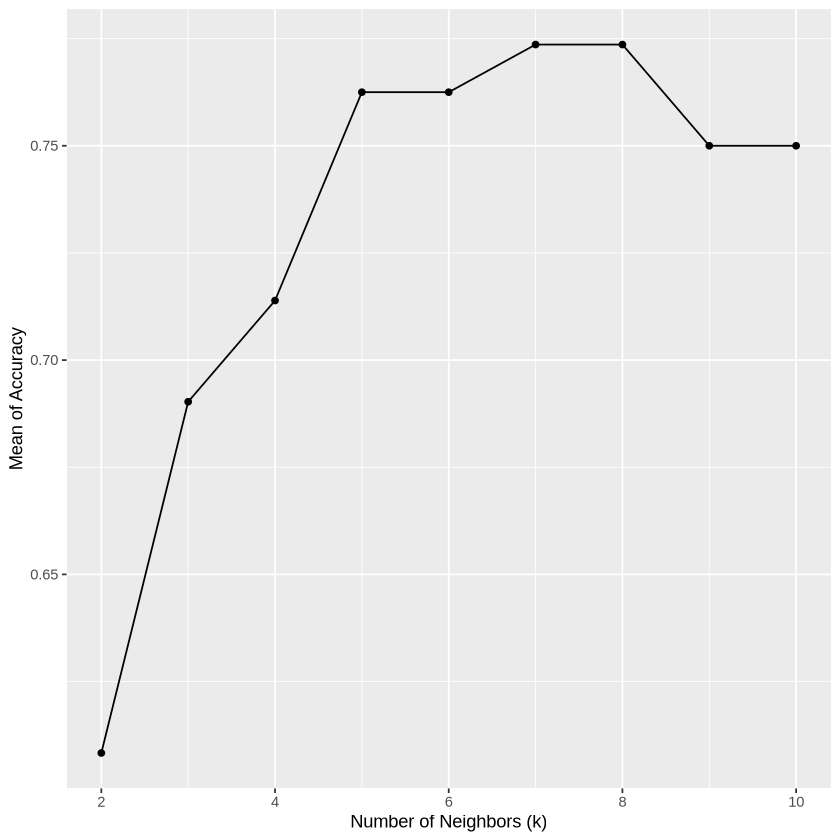

In [15]:
#Tuning k for Age+played_hours as predictors
set.seed(1234)

train_workflow <- workflow() |>
    add_recipe(newspaper_AH_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = train_fold, grid = k_vals) |>
    collect_metrics()

#Make the plot to see which k gives optimal accuracy
cross_val_plot <- train_workflow |>
    filter(.metric == 'accuracy') |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = 'Number of Neighbors (k)', y = 'Mean of Accuracy')

cross_val_plot

#plot shows that k=5 gives the highest accuracy (with least fluctutation around it)

In [18]:
#Now, using k=5 and newspaper_AH_recipe:
set.seed(1234)

newspaper_AH_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
    set_engine("kknn") |>
    set_mode("classification")
   

newspaper_AH_fit <- workflow() |>
    add_recipe(newspaper_AH_recipe) |>
    add_model(newspaper_AH_spec) |>
    fit(data = player_training)
newspaper_AH_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(7,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.202381
Best kernel: rectangular
Best k: 7

In [19]:
set.seed(1234)

#TESTING

newspaper_predictions <- predict(newspaper_AH_fit, player_testing) |>
    bind_cols(player_testing)
# newspaper_predictions

newspaper_metrics <- metrics(newspaper_predictions, truth = subscribe, estimate = .pred_class)
newspaper_metrics

newspaper_conf_mat <- conf_mat(newspaper_predictions, truth = subscribe, estimate = .pred_class)
newspaper_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6578947
kap,binary,-0.1382488


          Truth
Prediction FALSE TRUE
     FALSE     0    3
     TRUE     10   25

# 5. Discussion